# Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


# Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


import random
import matplotlib.pyplot as plt

import copy
from sklearn.model_selection import train_test_split

In [ ]:
!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.1 MB/s eta 0:00:00


# Load data

In [ ]:
data_no_aliens = np.load("No_aliens_float64.npz")
X_train_val = data_no_aliens['arr_0']
y_train_val = data_no_aliens['arr_1']

In [ ]:
big_rocks = [31, 56, 57, 140, 145, 158, 162, 241, 326, 382, 406, 443, 470, 475, 572, 614, 728, 737, 739, 813, 832, 849, 856, 872, 922, 985, 1026, 1030, 1125, 1162, 1168, 1169, 1182, 1266, 1337, 1443, 1456, 1475, 1491, 1526, 1527, 1544, 1576, 1633, 1684, 1781, 1792, 1883, 1919, 2014, 2055, 2086, 2102, 2111, 2156, 2193, 2199, 2253, 2331, 2351, 2412, 2417, 2498]

# Find images containing big rocks
if len(big_rocks) == 0:
  for i in range(len(X_train_val)):
    done = False
    for j in range(len(X_train_val[0])):
      for k in range(len(X_train_val[0][0])):
        if y_train_val[i][j][k] == 4:
          big_rocks.append(i)
          done = True
          break
      if done:
        break

print(len(big_rocks))
print(" ".join(map(str,big_rocks)))

# Find images not containing big rocks
without_big_rocks = [i for i in range(len(X_train_val)) if i not in big_rocks]
print(len(without_big_rocks))

63
31 56 57 140 145 158 162 241 326 382 406 443 470 475 572 614 728 737 739 813 832 849 856 872 922 985 1026 1030 1125 1162 1168 1169 1182 1266 1337 1443 1456 1475 1491 1526 1527 1544 1576 1633 1684 1781 1792 1883 1919 2014 2055 2086 2102 2111 2156 2193 2199 2253 2331 2351 2412 2417 2498
2442


In [ ]:
# Print the big rocks and their labels
for i in range((len(big_rocks)+1)//2):
  idx = big_rocks[2*i]

  if i == (len(big_rocks)+1)//2 - 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
  else:
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))

  axes[0].imshow(np.squeeze(X_train_val[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[1].imshow(np.squeeze(y_train_val[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[0].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[1].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[0].axis('off')
  axes[1].axis('off')

  if i == (len(big_rocks)+1)//2 - 1:
    break

  idx = big_rocks[2*i+1]
  axes[2].imshow(np.squeeze(X_train_val[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[3].imshow(np.squeeze(y_train_val[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[2].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[3].set_title(f'{idx}', y=1.0, fontsize=22, pad=-24, color='white')
  axes[2].axis('off')
  axes[3].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Find reasonably-sized big rocks
good_big_rocks = [31, 56, 140, 145, 158, 162, 241, 326, 382, 406, 443, 470, 475, 572, 614, 728, 737, 739, 813, 832, 849, 872, 985, 1026, 1030, 1125, 1162, 1182, 1266, 1337, 1443, 1456, 1526, 1527, 1544, 1576, 1633, 1781, 1792, 1883, 1919, 2014, 2055, 2086, 2111, 2193, 2199, 2253, 2331, 2412, 2417]
coords = np.full((len(good_big_rocks), 4), 129)

# Find the coordinates of the big rocks in thir respective images
if coords[0][0] == 129:
  for i in range(len(good_big_rocks)):
    for j in range(len(X_train_val[0])):
      for k in range(len(X_train_val[0][0])):
        if y_train_val[good_big_rocks[i]][j][k] == 4:
          if j < coords[i][0] or coords[i][0] == 129:
            coords[i][0] = j
          if j > coords[i][1] or coords[i][1] == 129:
            coords[i][1] = j
          if k < coords[i][2] or coords[i][2] == 129:
            coords[i][2] = k
          if k > coords[i][3] or coords[i][3] == 129:
            coords[i][3] = k

In [ ]:
rock_pics = []
rock_labels = []

# If an image contains multiple separate rocks, all but one end up in here
more_rock_pics = []
more_rock_labels = []

# Manual refinement of the coordinates
coords[2][1] = 25
coords[2][3] = 109
coords[4][3] = 57
coords[5][1] = 5
coords[5][3] = 11
coords[6][1] = 23
coords[7][1] = 15
coords[7][3] = 98
coords[9][1] = 57
coords[9][3] = 10
coords[10][0] = 31
coords[10][3] = 40
coords[21][0] = 21
coords[22][0] = 7
coords[24][0] = 53
coords[24][3] = 64
coords[32][1] = 20
coords[32][2] = 93
coords[33][1] = 6
coords[33][3] = 109
coords[38][1] = 39
coords[38][3] = 62
coords[45][1] = 54
coords[45][3] = 14
coords[46][1] = 39
coords[46][3] = 8
coords[48][3] = 26

# Automatically storing well-behaved big rocks
border = 2
for i in range(len(good_big_rocks)):
  if i not in [5, 9, 11, 14, 28, 30, 33, 46, 50]:
    y_up = max(coords[i][0] - border, 0)
    y_low = min(coords[i][1] + border, 64)
    x_left = max(coords[i][2] - border, 0)
    x_right = min(coords[i][3] + border, 128)
    rock_pics.append(X_train_val[good_big_rocks[i]][y_up:y_low, x_left:x_right])
    rock_labels.append(y_train_val[good_big_rocks[i]][y_up:y_low, x_left:x_right])

# Manually storing rocks that were part of a multi-bigrock picture
more_rock_pics.append(X_train_val[good_big_rocks[2]][49 - border:63 + border, 106 - border:max(127 + border, 128)])
more_rock_labels.append(y_train_val[good_big_rocks[2]][49 - border:63 + border, 106 - border:max(127 + border, 128)])

more_rock_pics.append(X_train_val[good_big_rocks[4]][11 - border:30 + border:, 55 - border:111 + border])
more_rock_labels.append(y_train_val[good_big_rocks[4]][11 - border:30 + border:, 55 - border:111 + border])

more_rock_pics.append(X_train_val[good_big_rocks[5]][18 - border:36 + border, max(0 - border, 0):17 + border])
more_rock_labels.append(y_train_val[good_big_rocks[5]][18 - border:36 + border, max(0 - border, 0):17 + border])

#more_rock_pics.append(X_train_val[good_big_rocks[5]][22 - border:32 + border, 106 - border:110 + border])
#more_rock_labels.append(y_train_val[good_big_rocks[5]][22 - border:32 + border, 106 - border:110 + border])

more_rock_pics.append(X_train_val[good_big_rocks[6]][58 - border:64 + border, 73 - border:86 + border])
more_rock_labels.append(y_train_val[good_big_rocks[6]][58 - border:64 + border, 73 - border:86 + border])

#more_rock_pics.append(X_train_val[good_big_rocks[7]][9 - border:11 + border, 120 - border:min(128 + border, 128)])
#more_rock_labels.append(y_train_val[good_big_rocks[7]][9 - border:11 + border, 120 - border:min(128 + border, 128)])

#more_rock_pics.append(X_train_val[good_big_rocks[7]][34 - border:40 + border, 123 - border:min(128 + border, 128)])
#more_rock_labels.append(y_train_val[good_big_rocks[7]][34 - border:40 + border, 123 - border:min(128 + border, 128)])

more_rock_pics.append(X_train_val[good_big_rocks[10]][max(0 - border, 0):37 + border, 44 - border:min(128 + border, 128)])
more_rock_labels.append(y_train_val[good_big_rocks[10]][max(0 - border, 0):37 + border, 44 - border:min(128 + border, 128)])

#more_rock_pics.append(X_train_val[good_big_rocks[24]][max(0 - border, 0):4 + border, 97 - border:min(128 + border, 128)])
#more_rock_labels.append(y_train_val[good_big_rocks[24]][max(0 - border, 0):4 + border, 97 - border:min(128 + border, 128)])

more_rock_pics.append(X_train_val[good_big_rocks[33]][12 - border:30 + border, 109 - border:min(128 + border, 128)])
more_rock_labels.append(y_train_val[good_big_rocks[33]][12 - border:30 + border, 109 - border:min(128 + border, 128)])

more_rock_pics.append(X_train_val[good_big_rocks[38]][42 - border:62 + border, 9 - border:23 + border])
more_rock_labels.append(y_train_val[good_big_rocks[38]][42 - border:62 + border, 9 - border:23 + border])

more_rock_pics.append(X_train_val[good_big_rocks[45]][41 - border:54 + border, 28 - border:88 + border])
more_rock_labels.append(y_train_val[good_big_rocks[45]][41 - border:54 + border, 28 - border:88 + border])

#more_rock_pics.append(X_train_val[good_big_rocks[46]][58 - border:64 + border, 110 - border:min(124 + border, 128)])
#more_rock_labels.append(y_train_val[good_big_rocks[46]][58 - border:64 + border, 110 - border:min(124 + border, 128)])

<ipython-input-9-93aa9d462441>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(10, 10))


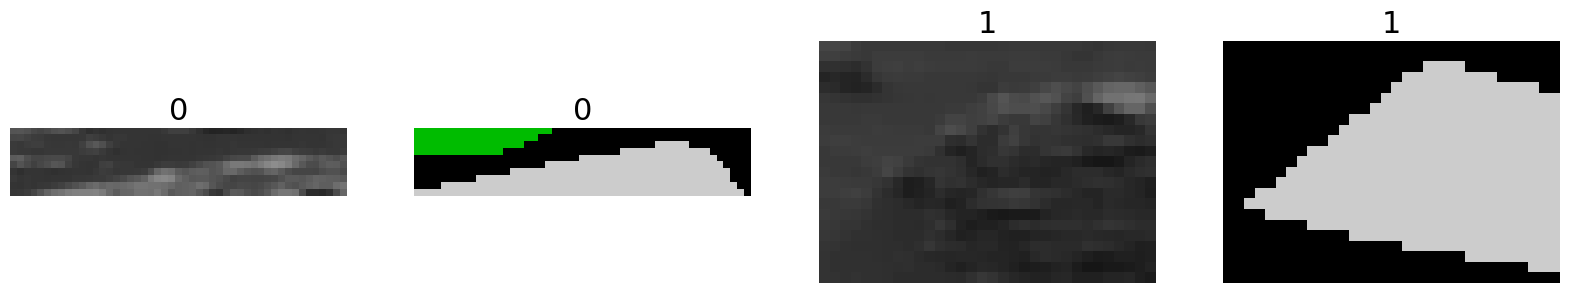

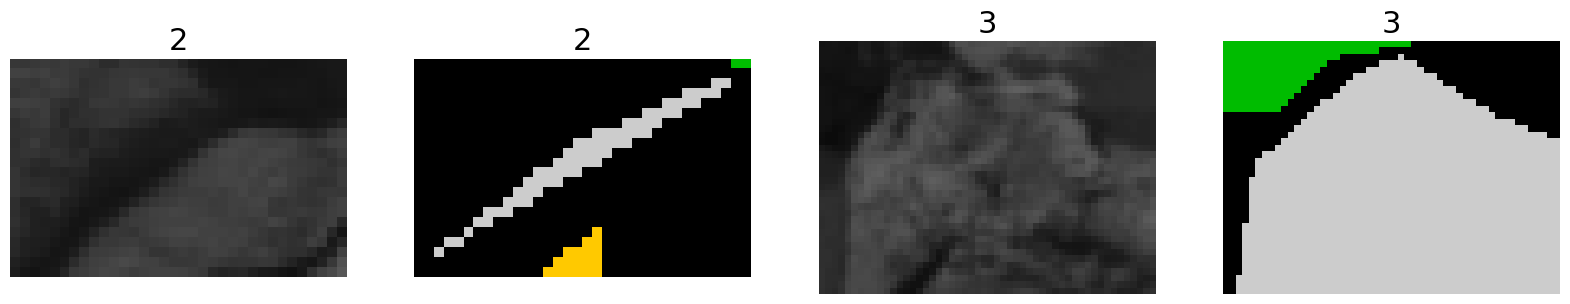

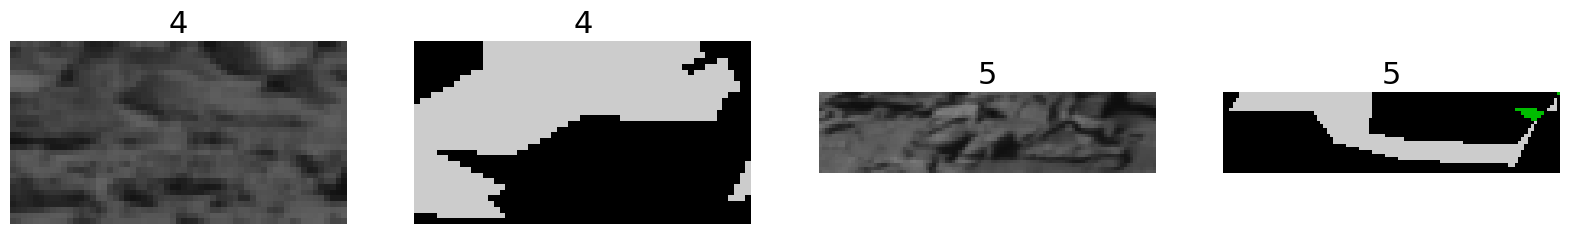

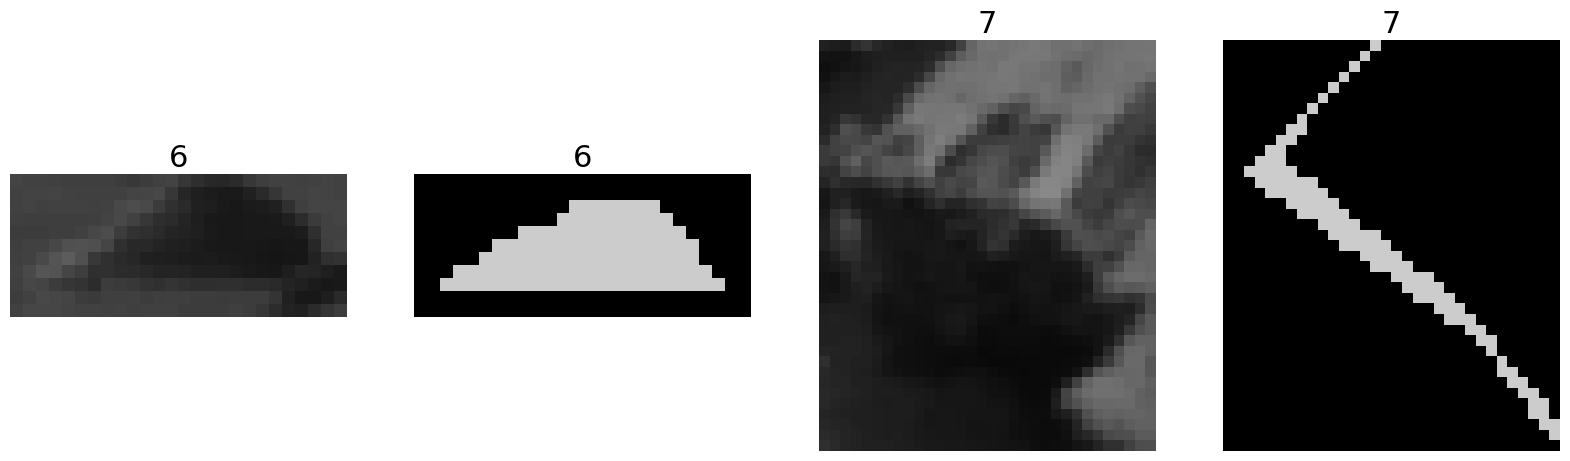

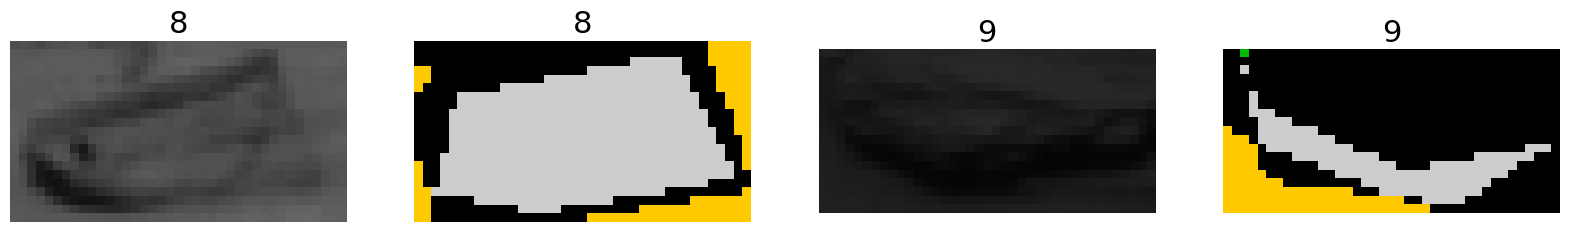

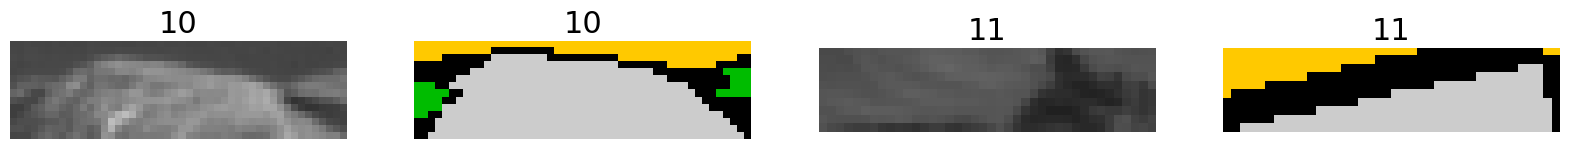

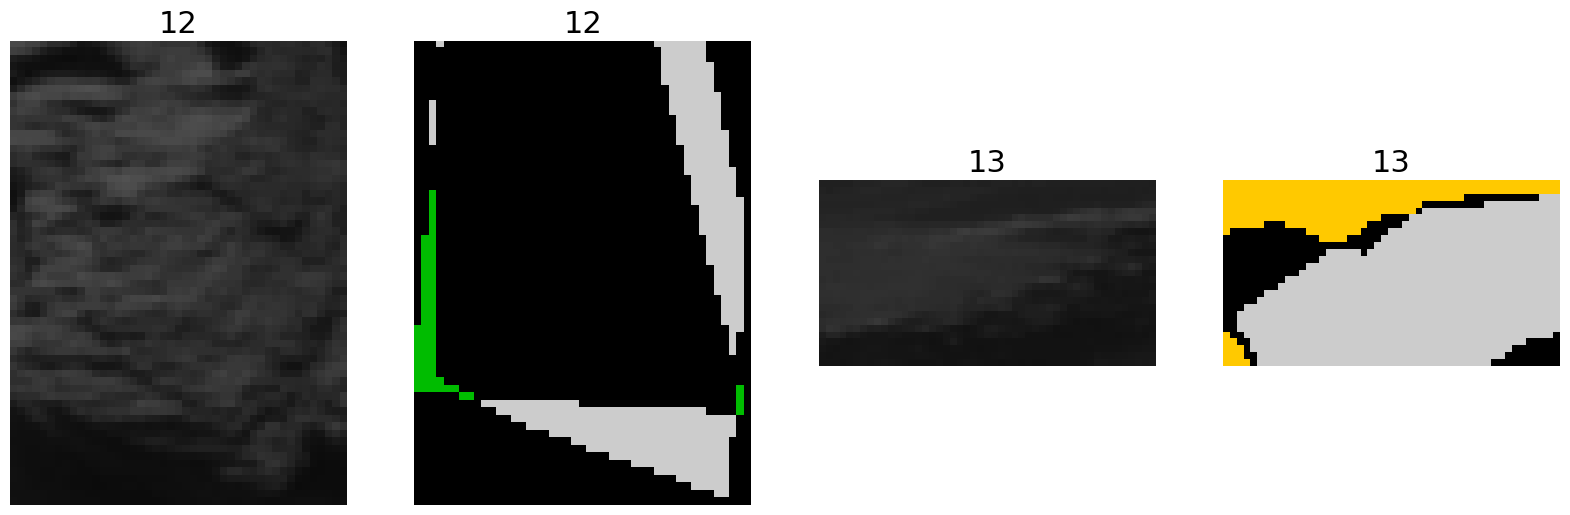

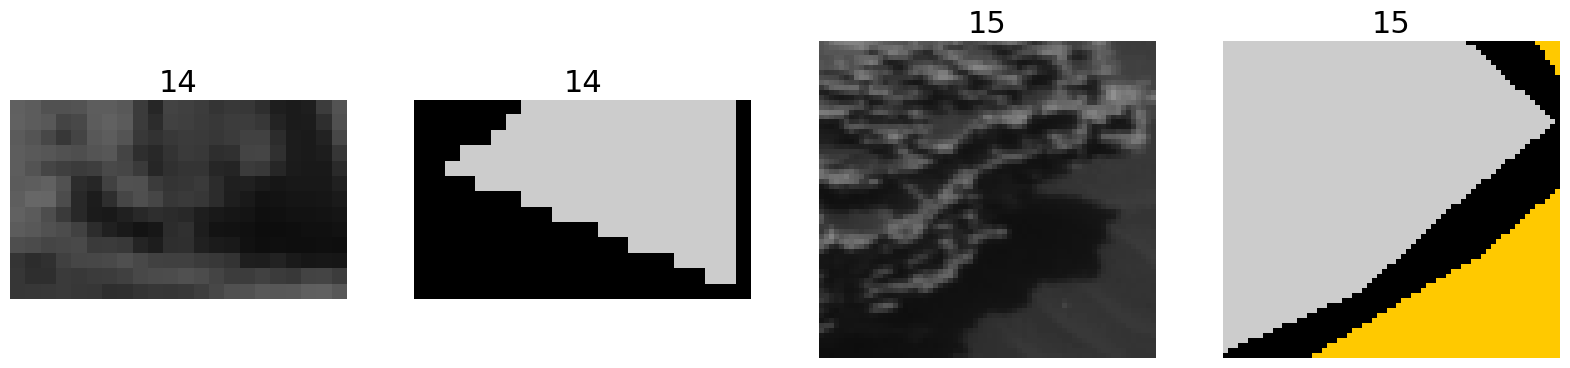

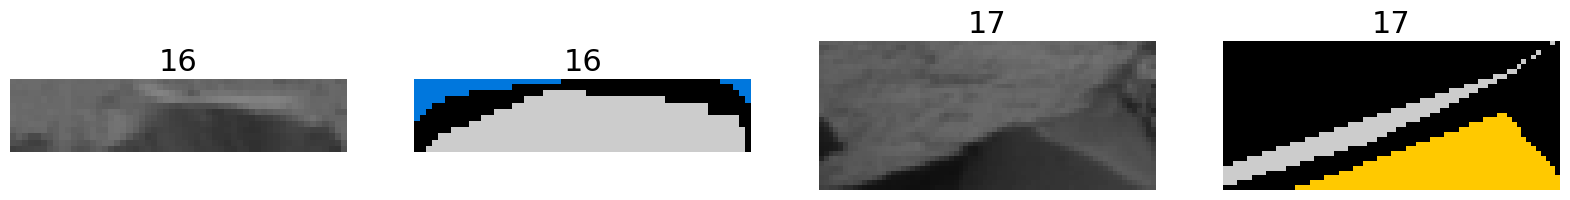

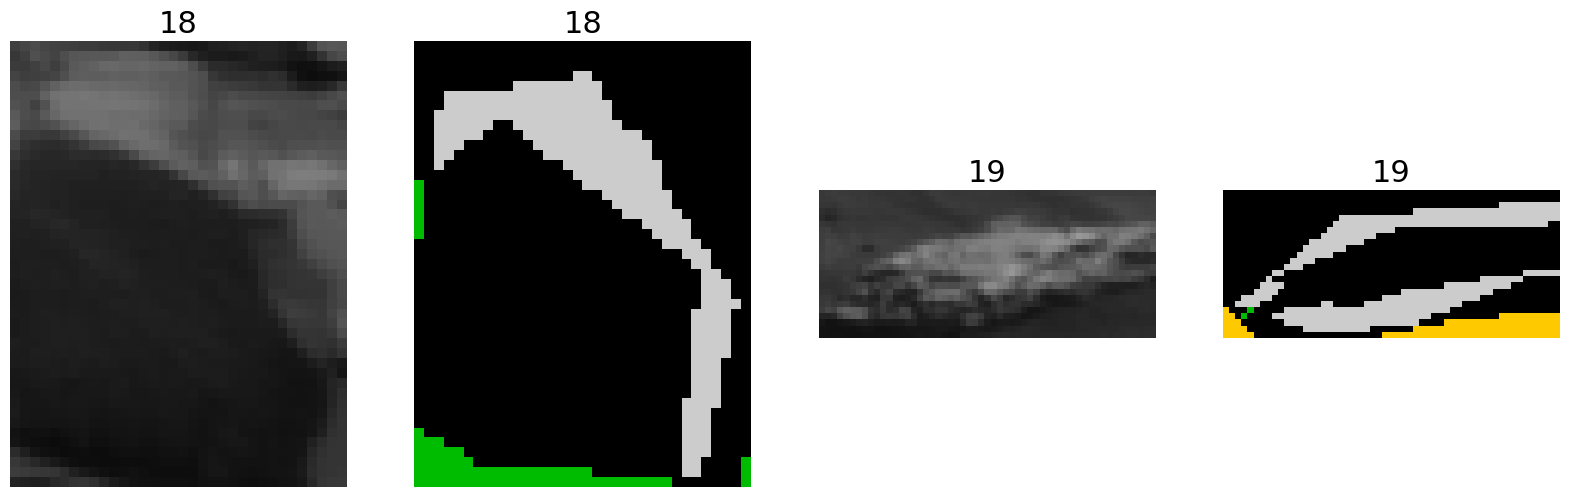

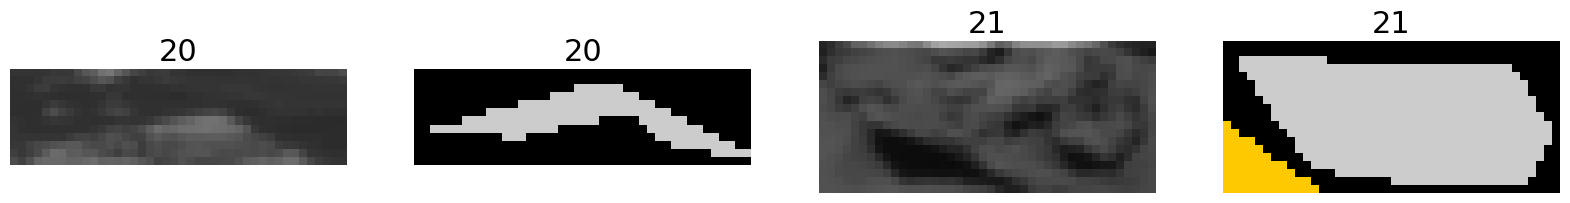

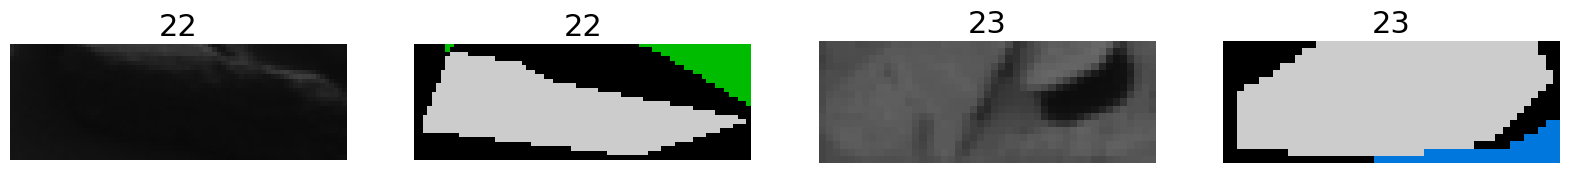

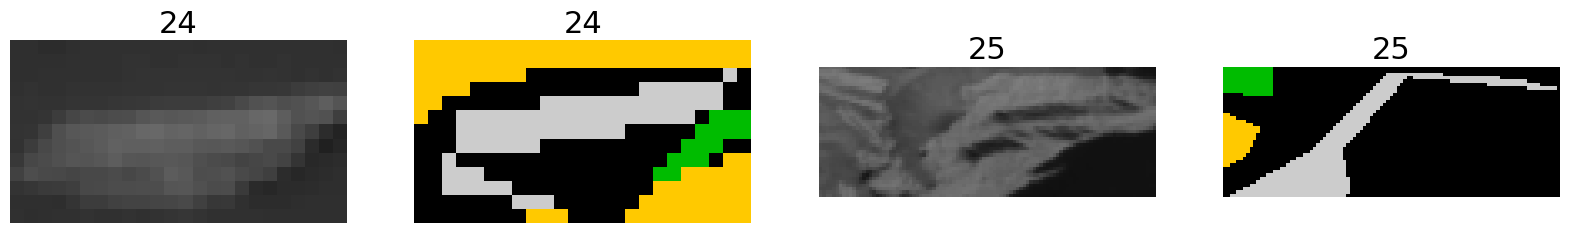

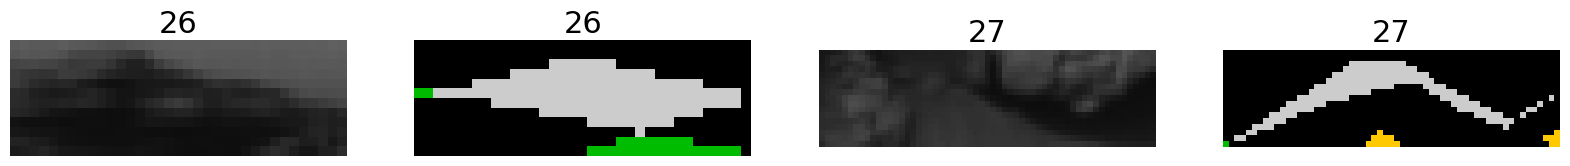

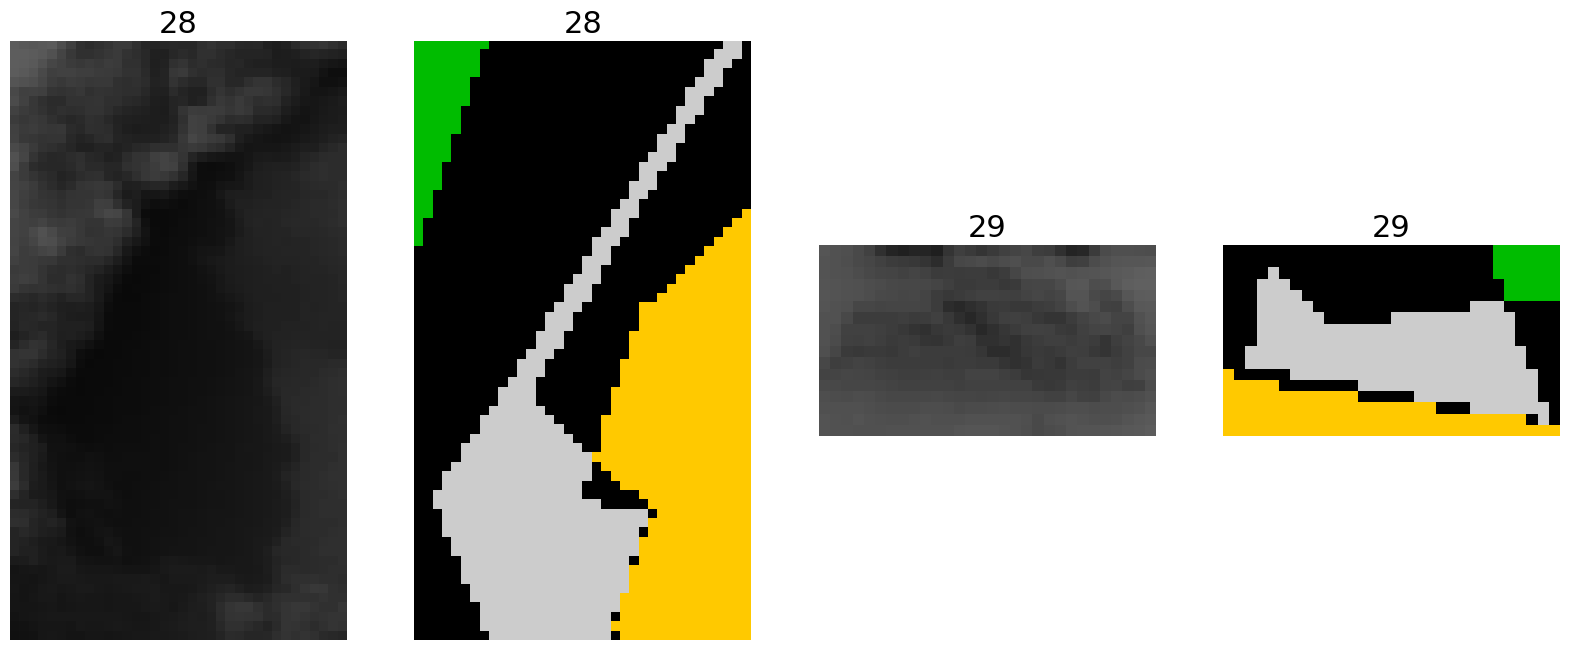

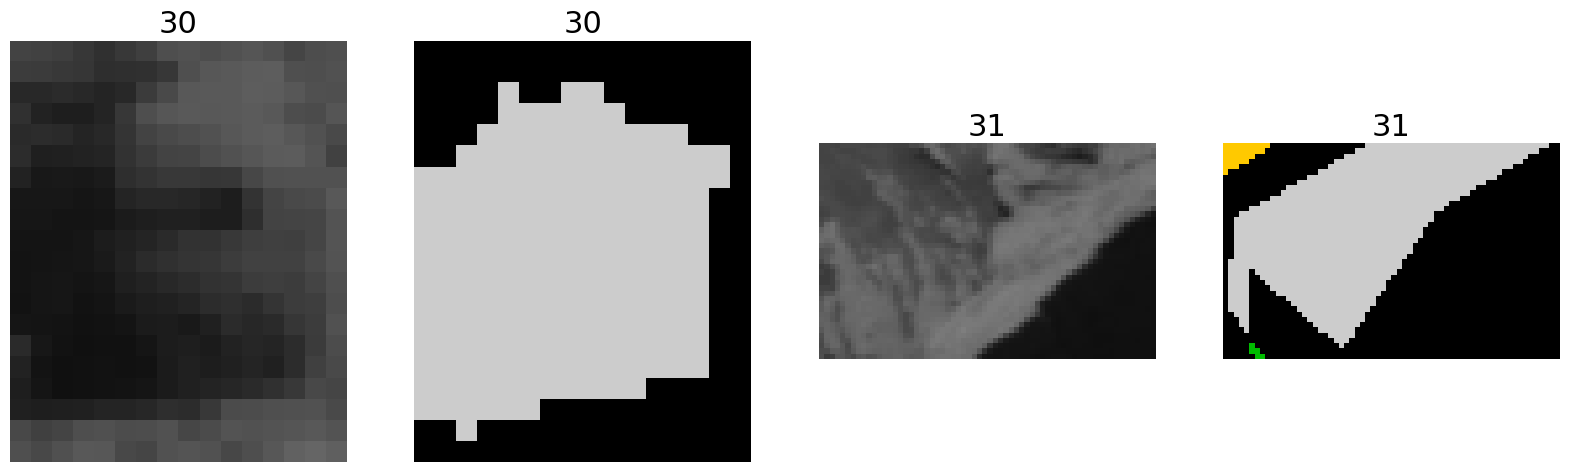

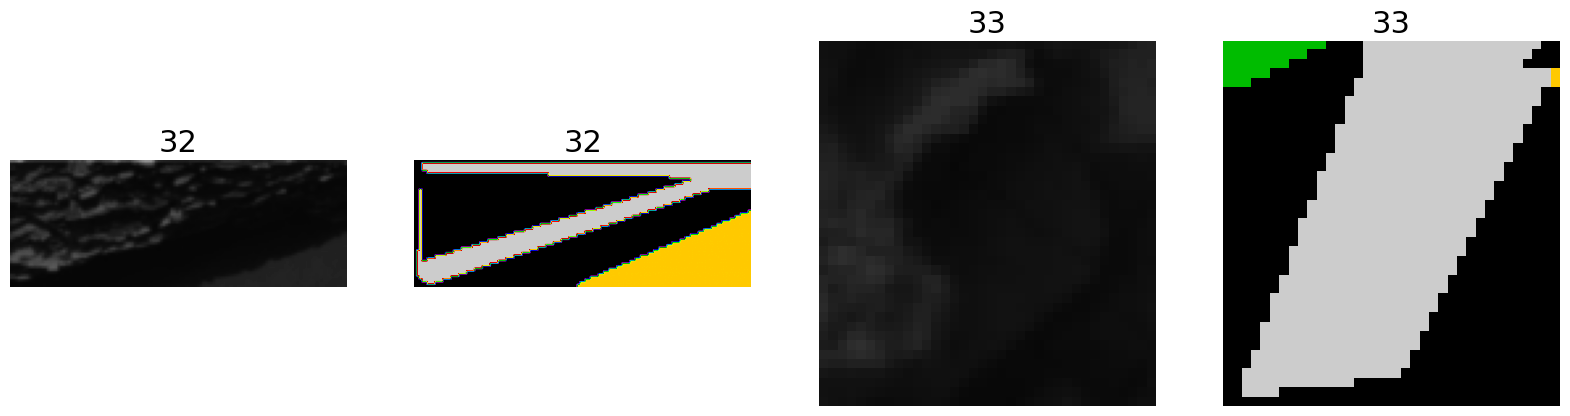

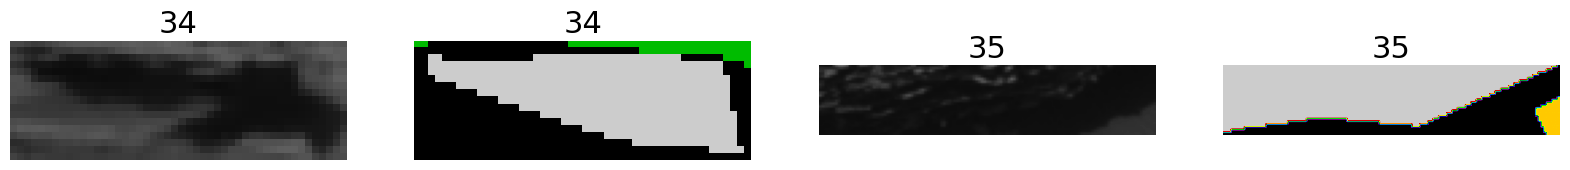

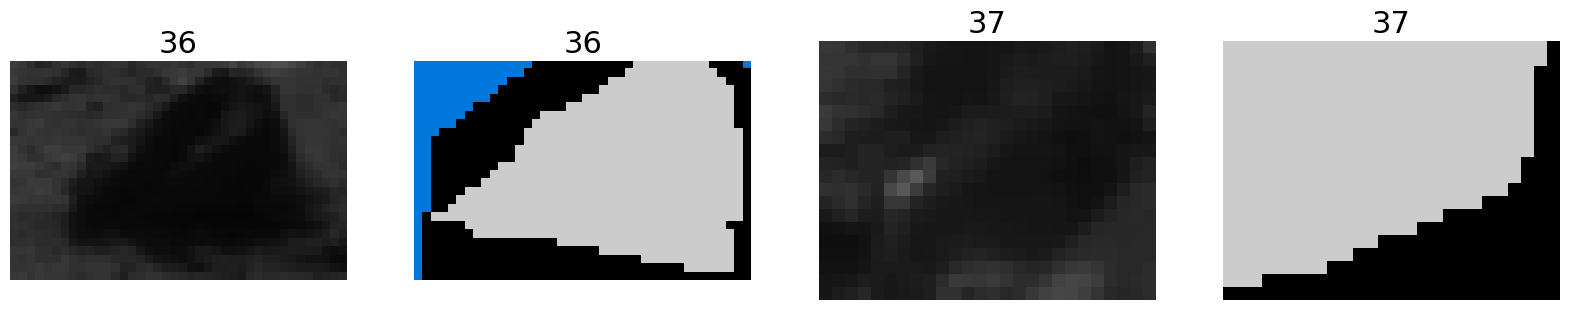

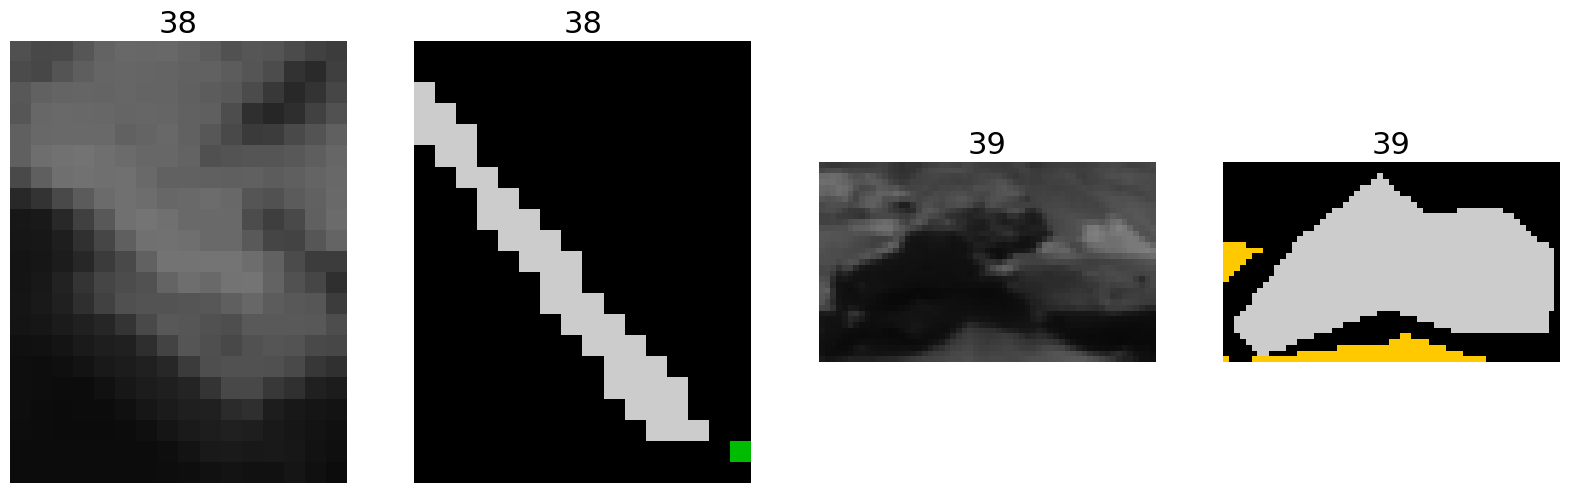

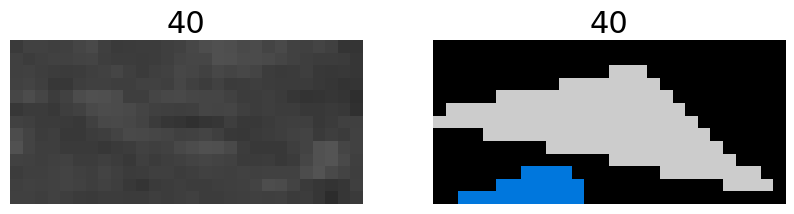

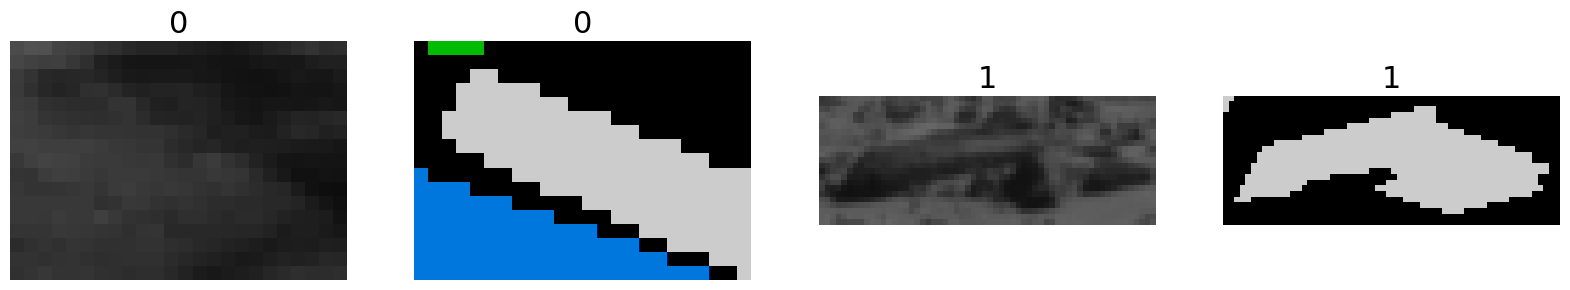

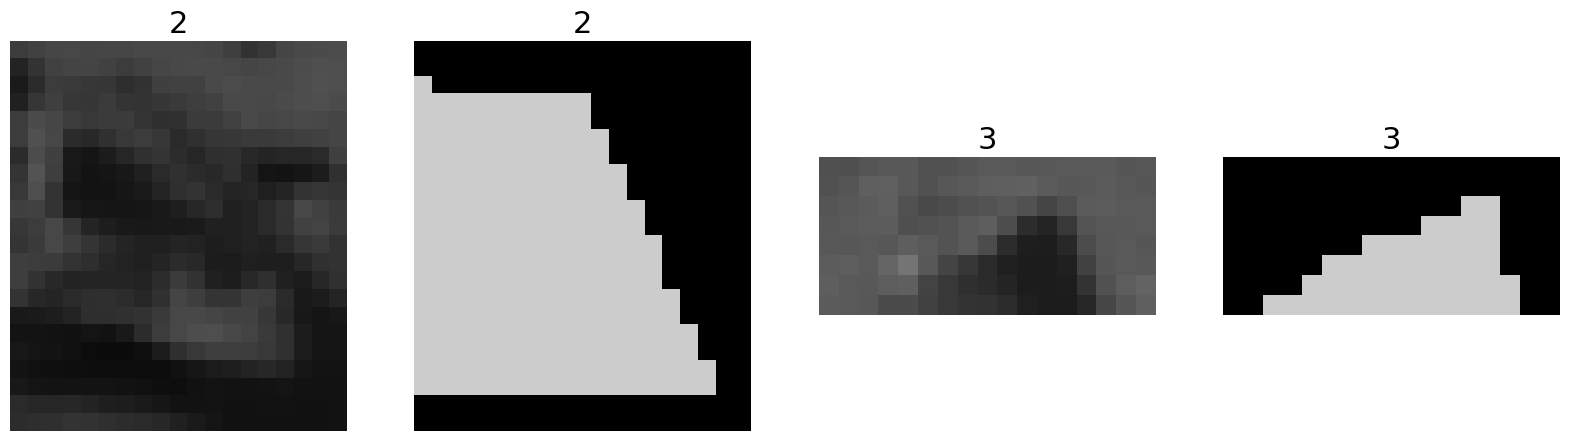

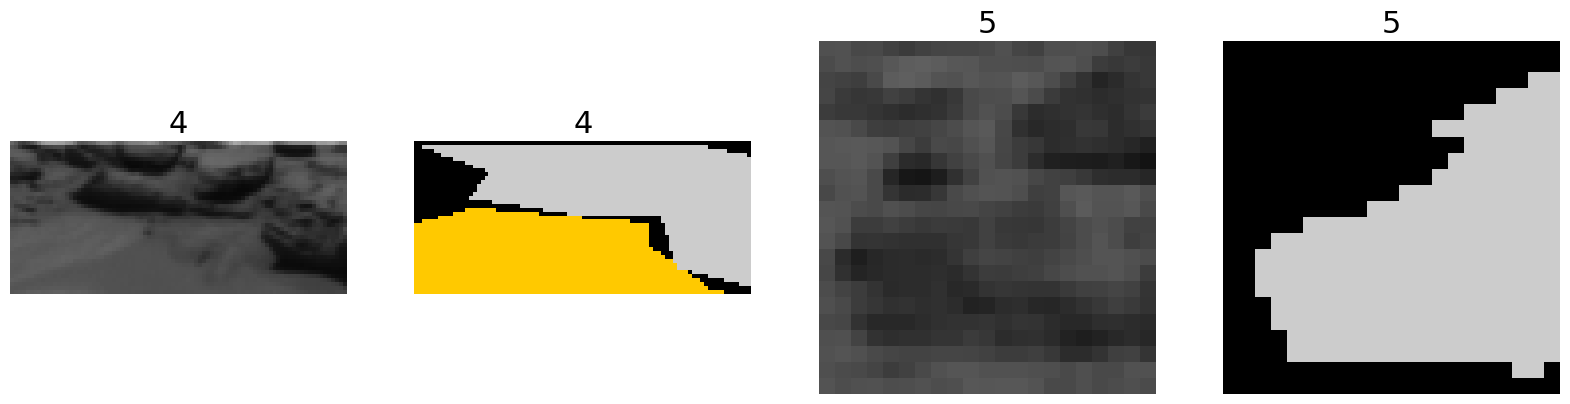

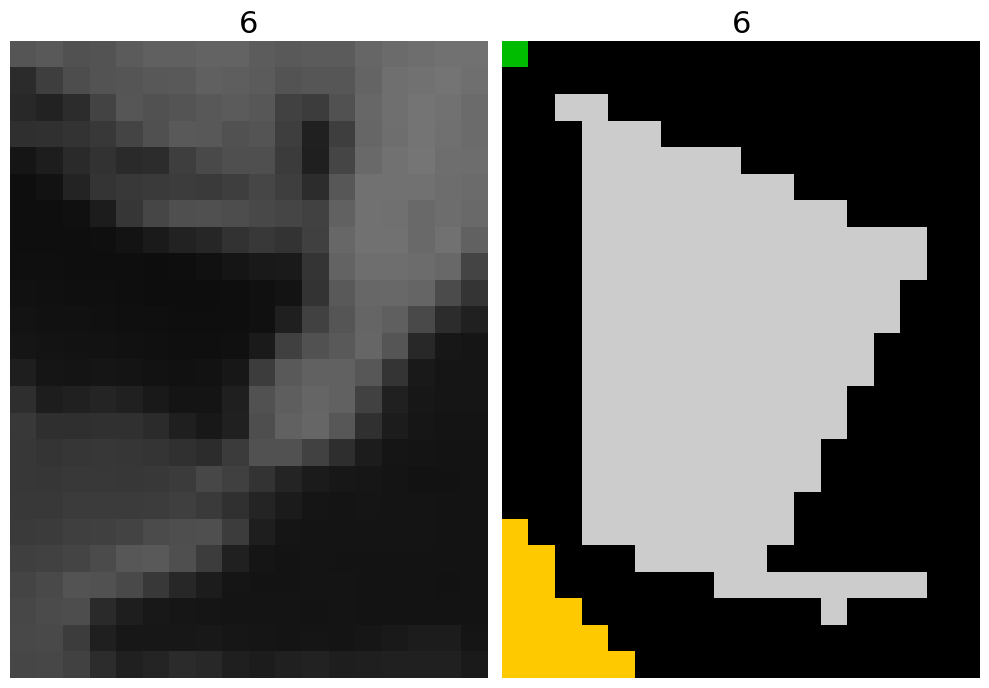

In [ ]:
# Displaying big rocks pieces and their labels
for i in range((len(rock_pics)+1)//2):
  idx = 2*i

  if i == (len(rock_pics)+1)//2 - 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
  else:
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))

  axes[0].imshow(np.squeeze(rock_pics[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[1].imshow(np.squeeze(rock_labels[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[0].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[1].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[0].axis('off')
  axes[1].axis('off')

  if i == (len(rock_pics)+1)//2 - 1:
    break

  idx = 2*i+1
  axes[2].imshow(np.squeeze(rock_pics[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[3].imshow(np.squeeze(rock_labels[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[2].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[3].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[2].axis('off')
  axes[3].axis('off')

for i in range((len(more_rock_pics)+1)//2):
  idx = 2*i

  if i == (len(more_rock_pics)+1)//2 - 1:
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
  else:
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))

  axes[0].imshow(np.squeeze(more_rock_pics[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[1].imshow(np.squeeze(more_rock_labels[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[0].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[1].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[0].axis('off')
  axes[1].axis('off')

  if i == (len(more_rock_pics)+1)//2 - 1:
    break

  idx = 2*i+1
  axes[2].imshow(np.squeeze(more_rock_pics[idx]), cmap = 'grey',vmin=0, vmax=255)
  axes[3].imshow(np.squeeze(more_rock_labels[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
  axes[2].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[3].set_title(f'{idx}', y=1.0, fontsize=22)
  axes[2].axis('off')
  axes[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Concatenating all rock pieces
rock_pics = rock_pics + more_rock_pics
rock_labels = rock_labels + more_rock_labels
print(len(rock_pics))

50


# Apply CutMix

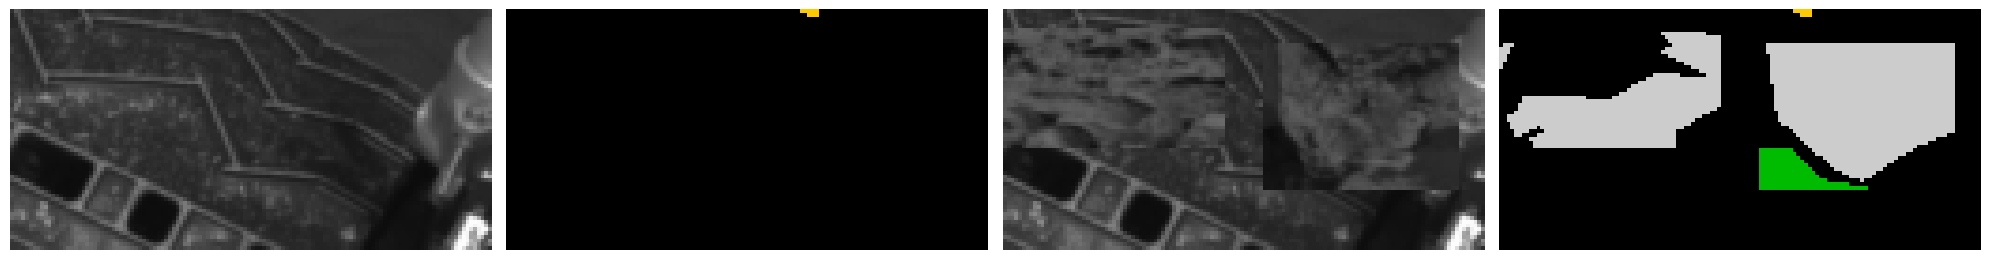

In [ ]:
# Define the cutmixing function to paste one single rock
def paste_rock(image, image_label, rock, rock_label):
  rnd = [64, 128]

  # Look for suitable indices (the pasted rock has to lie in the boundaries of the original picture)
  while rnd[0] + rock.shape[0] > image.shape[0] or rnd[1] + rock.shape[1] > image.shape[1]:
    # Randomly rotate the rock piece
    aug = [random.uniform(0, 1), random.uniform(0, 1), random.randint(1, 4)]
    if aug[0] > 0.5:
      rock = np.rot90(rock, k=aug[2], axes=(0, 1))
      rock_label = np.rot90(rock_label, k=aug[2], axes=(0, 1))
    if aug[1] > 0.5:
      rock = np.flip(rock, axis=0)
      rock_label = np.flip(rock_label, axis=0)

    rnd = [random.randint(0, 64), random.randint(0, 128)]

  # Paste the rock and it's label in the appropriate place
  image[rnd[0]:rnd[0] + rock.shape[0], rnd[1]:rnd[1] + rock.shape[1]] = rock
  image_label[rnd[0]:rnd[0] + rock.shape[0], rnd[1]:rnd[1] + rock.shape[1]] = rock_label

  return image, image_label

# Check if two intervals intersect
def intervals_intersect(start1, end1, start2, end2):
    return not (end1 < start2 or end2 < start1)

# Define the cutmixing function to paste two rocks
def paste_rocks(image, image_label, rock1, rock_label1, rock2, rock_label2, max_tries = 5000):
  rnd = [64, 128, 64, 128]

  i = 0
  # Look for suitable indices (the pasted rocks have to lie in the boundaries of the original picture and they mustn't intersect)
  while i < max_tries and (rnd[0] + rock1.shape[0] > image.shape[0] or rnd[1] + rock1.shape[1] > image.shape[1]) or (rnd[2] + rock2.shape[0] > image.shape[0] or rnd[3] + rock2.shape[1] > image.shape[1]) or (intervals_intersect(rnd[0], rnd[0] + rock1.shape[0], rnd[2], rnd[2] + rock2.shape[0]) and intervals_intersect(rnd[1], rnd[1] + rock1.shape[1], rnd[3], rnd[3] + rock2.shape[1])):
    # Randomly rotate the rock pieces
    aug1 = [random.uniform(0, 1), random.uniform(0, 1), random.randint(1, 4)]
    aug2 = [random.uniform(0, 1), random.uniform(0, 1), random.randint(1, 4)]
    if aug1[0] > 0.5:
      rock1 = np.rot90(rock1, k=aug1[2], axes=(0, 1))
      rock_label1 = np.rot90(rock_label1, k=aug1[2], axes=(0, 1))
    if aug1[1] > 0.5:
      rock1 = np.flip(rock1, axis=0)
      rock_label1 = np.flip(rock_label1, axis=0)
    if aug2[0] > 0.5:
      rock2 = np.rot90(rock2, k=aug2[2], axes=(0, 1))
      rock_label2 = np.rot90(rock_label2, k=aug2[2], axes=(0, 1))
    if aug2[1] > 0.5:
      rock2 = np.flip(rock2, axis=0)
      rock_label2 = np.flip(rock_label2, axis=0)

    rnd = [random.randint(0, 64), random.randint(0, 128), random.randint(0, 64), random.randint(0, 128)]
    i += 1

  # Paste the rocks and their labels in the appropriate place
  if i < max_tries:
    image[rnd[0]:rnd[0] + rock1.shape[0], rnd[1]:rnd[1] + rock1.shape[1]] = rock1
    image_label[rnd[0]:rnd[0] + rock1.shape[0], rnd[1]:rnd[1] + rock1.shape[1]] = rock_label1

    image[rnd[2]:rnd[2] + rock2.shape[0], rnd[3]:rnd[3] + rock2.shape[1]] = rock2
    image_label[rnd[2]:rnd[2] + rock2.shape[0], rnd[3]:rnd[3] + rock2.shape[1]] = rock_label2

  return image, image_label

# Show an example of cutmix
pic_idx = 2
rock_idx1 = 3
rock_idx2 = 4
to_plot1, to_plot2 = paste_rocks(copy.copy(X_train_val[without_big_rocks[pic_idx]]), copy.copy(y_train_val[without_big_rocks[pic_idx]]), rock_pics[rock_idx1], rock_labels[rock_idx1], rock_pics[rock_idx2], rock_labels[rock_idx2])
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(np.squeeze(X_train_val[without_big_rocks[pic_idx]]), cmap = 'grey',vmin=0, vmax=255)
axes[1].imshow(np.squeeze(y_train_val[without_big_rocks[pic_idx]]), cmap = 'nipy_spectral',vmin=0, vmax=4)
axes[2].imshow(np.squeeze(to_plot1), cmap = 'grey',vmin=0, vmax=255)
axes[3].imshow(np.squeeze(to_plot2), cmap = 'nipy_spectral',vmin=0, vmax=4)
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into a training and a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_val[without_big_rocks], y_train_val[without_big_rocks], test_size = 0.1)

# Store some rocks for validation
val_rocks = [0, 1, 3, 8, 12, 13]
train_rocks = [i for i in range(len(rock_pics)) if i not in val_rocks]

# Select images to augment with cutmix (they mustn't be a rover selfie)
train_to_augment = []
pixels_per_image = 64 * 128
while len(train_to_augment) < 500:
  idx = random.randint(0, len(X_train) - 1)
  if idx not in train_to_augment:
    background_pixels = 0
    for i in range(len(X_train[0])):
      for j in range(len(X_train[0][0])):
        if X_train[idx][i][j] == 0:
          background_pixels += 1

    if background_pixels < pixels_per_image * 0.9:
      train_to_augment.append(idx)

train_augmented = []
train_label_augmented = []

# Apply cutmix on the selected images
for i in range(len(train_to_augment)):
  rnd = random.uniform(0, 1)
  if rnd > 0.5:
    rndrock = random.sample(range(len(train_rocks)), 1)
    ta, la =  paste_rock(copy.copy(X_train[train_to_augment[i]]), copy.copy(y_train[train_to_augment[i]]), rock_pics[train_rocks[rndrock[0]]], rock_labels[train_rocks[rndrock[0]]])
    train_augmented.append(ta)
    train_label_augmented.append(la)
  else:
    rndrock = random.sample(range(len(train_rocks)), 2)
    ta, la = paste_rocks(copy.copy(X_train[train_to_augment[i]]), copy.copy(y_train[train_to_augment[i]]), rock_pics[train_rocks[rndrock[0]]], rock_labels[train_rocks[rndrock[0]]], rock_pics[train_rocks[rndrock[1]]], rock_labels[train_rocks[rndrock[1]]])
    train_augmented.append(ta)
    train_label_augmented.append(la)

# Concatenate the cutmixed samples
X_train = np.concatenate([X_train, train_augmented])
y_train = np.concatenate([y_train, train_label_augmented])

# Put the original rock pictures back into the dataset
for i in range(len(big_rocks)):
  if(big_rocks[i] not in val_rocks):
    X_train = np.append(X_train, np.expand_dims(X_train_val[big_rocks[i]], axis=0), axis=0)
    y_train = np.append(y_train, np.expand_dims(y_train_val[big_rocks[i]], axis = 0), axis = 0)
  else:
    X_val = np.append(X_val, np.expand_dims(X_train_val[big_rocks[i]], axis=0), axis=0)
    y_val = np.append(y_val, np.expand_dims(y_train_val[big_rocks[i]], axis = 0), axis = 0)

In [ ]:
# Cast the dataset to the uint8 data type
X_train = tf.cast(X_train, tf.uint8)
y_train = tf.cast(y_train, tf.uint8)
X_val = tf.cast(X_val, tf.uint8)
y_val = tf.cast(y_val, tf.uint8)

# Visualize the augmented data

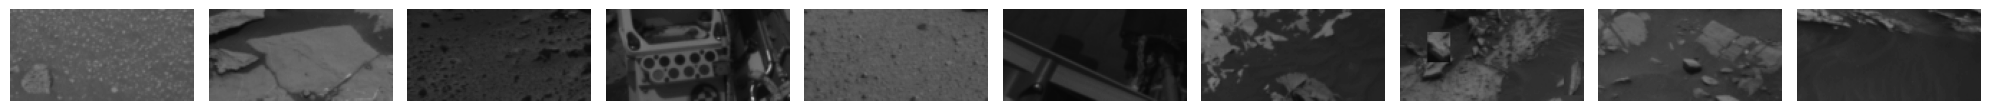

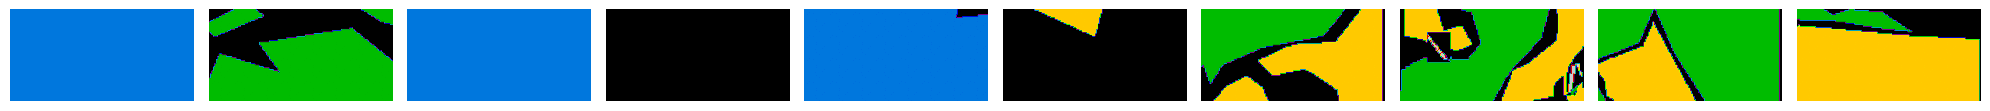

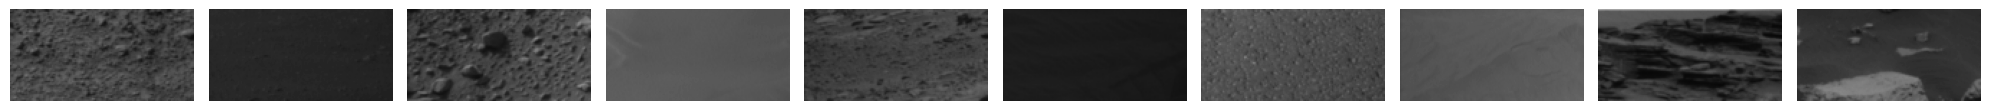

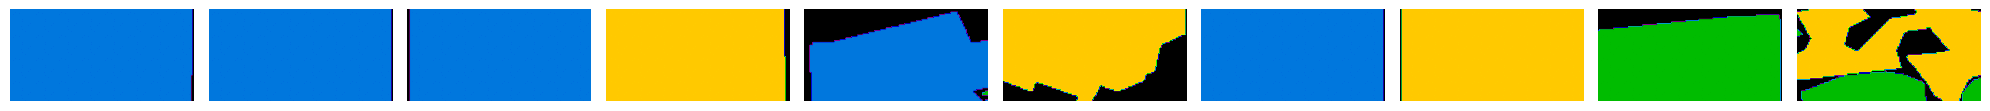

In [ ]:
# Display a sample of images from the new training dataset
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train[idx]),cmap = 'grey',vmin=0, vmax=255)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(y_train[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Display a sample of images from the new validation dataset
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_val[idx]),cmap = 'grey',vmin=0, vmax=255)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(y_val[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Save the new data

In [ ]:
# Save the new dataset to a file
np.savez('BigRocks', X_train, y_train, X_val, y_val)